# 1. Introduction

This notebook provides a quick overview of how to apply transfer learning and flow batch processing of "relatviely large" datasets for neural networks and deep learning.

# 2. Objection

> 1) Classfiy crack 

> 2) Understanding transfer learning

> 3) Understanding CNN (neural networks)

> 4) Understanding deep learning

# 3. Import libraries

In [1]:
# importing library to handle files
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # CPU만 사용할 경우 설정

# importing libray to handle status bars
from tqdm.notebook import tqdm

# import libray to ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.image import imread

# 4. Preprocessing

In [2]:
# initializing lists to store file paths for training and validation
img_paths = []

# importing libraries to store label references
labels = []

# iterating through directories
for dirname, _, filenames in os.walk(YOUR_SURFACE_CRACK_IMAGE_FOLDER_PATH):
    for filename in filenames:
        
        path = os.path.join(dirname, filename)
        
        if '.jpg' in path:
        
            img_paths.append(path)
            labels.append(path.split(os.path.sep)[-2])

In [3]:
# dataframes for training, validation and test datasets
main_df = pd.DataFrame({'Path': img_paths, 'Label': labels}).sample(frac = 1,
                                                                    random_state = 10)

oX_train, X_test, oy_train, y_test = train_test_split(main_df['Path'], main_df['Label'], test_size = 0.2,
                                                      stratify = main_df['Label'], 
                                                      shuffle = True, random_state = 20)

X_train, X_val, y_train, y_val = train_test_split(oX_train, oy_train, test_size = 0.2,
                                                  stratify = oy_train, 
                                                  shuffle = True, random_state = 40)

# train dataframe
train_df = pd.DataFrame({'Path': X_train, 'Label': y_train})

# validation dataframe
val_df = pd.DataFrame({'Path': X_val, 'Label': y_val})

# test dataframe
test_df = pd.DataFrame({'Path': X_test, 'Label': y_test})

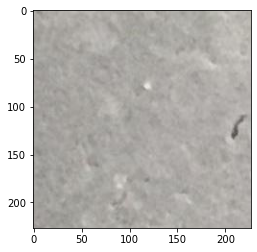

In [4]:
plt.imshow(imread(img_paths[0]))

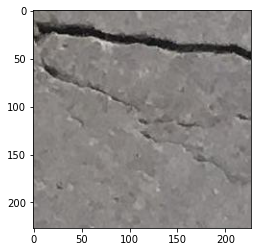

In [5]:
plt.imshow(imread(img_paths[-1]))

# 5. Data augmentation

In [6]:
# setting image dimensions
IMAGE_DIMS = (224, 224, 3)

# loading preprocessing function
prep_func = tf.keras.applications.vgg16.preprocess_input 
        
# importing pretrained model
vgg_model = tf.keras.applications.vgg16.VGG16(input_shape = IMAGE_DIMS,
                                              include_top = False, weights = 'imagenet')
        
# freezing layers in pretrained model
for layer in vgg_model.layers:
    layer.trainable = False

In [7]:
def df_augment(prep_func, rot_range=None, zoom_range=None, width_shift=None, height_shift=None, hor_flip=None,
               ver_flip=None):
    dataset_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=prep_func,
                                                                      rotation_range=rot_range,
                                                                      zoom_range=zoom_range,
                                                                      width_shift_range=width_shift,
                                                                      height_shift_range=height_shift,
                                                                      horizontal_flip=hor_flip,
                                                                      vertical_flip=ver_flip)
    return dataset_datagen

In [8]:
def dataset_generator(batch_size, dataset_datagen, dataset_df, cls_mod=None, shuf=True):
    dataset_batch = batch_size

    dataset_generator = dataset_datagen.flow_from_dataframe(dataframe=dataset_df, x_col='Path', y_col='Label',
                                                            target_size=(IMAGE_DIMS[1], IMAGE_DIMS[0]),
                                                            batch_size=batch_size, class_mode=cls_mod,
                                                            shuffle=shuf)

    return dataset_batch, dataset_generator

In [9]:
# dataset generator
train_datagen = df_augment(prep_func, rot_range=10, zoom_range=0.1, width_shift=0.1, height_shift=0.1,
                           hor_flip=True, ver_flip=True)

val_datagen = df_augment(prep_func, rot_range=0, zoom_range=0, width_shift=0, height_shift=0,
                         hor_flip=False, ver_flip=False)

In [10]:
train_bs, train_generator = dataset_generator(batch_size=16, dataset_datagen=train_datagen, dataset_df=train_df,
                                              cls_mod='binary', shuf=True)
val_bs, val_generator = dataset_generator(batch_size=16, dataset_datagen=val_datagen, dataset_df=val_df,
                                          cls_mod='binary', shuf=False)
test_bs, test_generator = dataset_generator(batch_size=16, dataset_datagen=val_datagen, dataset_df=test_df,
                                            cls_mod='binary', shuf=False)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [11]:
def model_structure(vgg_model):
    # defining a sequential model to learn
    clf_model = tf.keras.Sequential()

    # adding pretrained model
    clf_model.add(vgg_model)

    # using global average pooling instead of flatten and global max pooling
    clf_model.add(tf.keras.layers.GlobalAveragePooling2D())

    clf_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
    clf_model.add(tf.keras.layers.Dropout(0.3))

    clf_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
    clf_model.add(tf.keras.layers.Dropout(0.3))

    clf_model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

    clf_model.summary()
    clf_model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
    return clf_model

In [12]:
def model_params(train_df, val_df, test_df, train_bs, val_bs, test_bs):
    steps_train = np.ceil(train_df.shape[0] / train_bs)
    steps_val = np.ceil(val_df.shape[0] / val_bs)
    steps_test = np.ceil(test_df.shape[0] / test_bs)
    print("Steps for training:", str(steps_train) + ',', "validation:", str(steps_val) + ',',
          "testing:", str(steps_test))
    return steps_train, steps_val, steps_test

In [13]:
def model_train(model, train_generator, steps_train, val_generator, steps_val):
    history = model.fit(train_generator, steps_per_epoch=steps_train, validation_data=val_generator, epochs=1,
                        validation_steps=steps_val, verbose=1)
    return history

In [14]:
def model_eval(model, test_generator, steps_test):
    model_val = model.evaluate_generator(test_generator, steps=steps_test, verbose=1)
    return model_val

In [15]:
# model
clf_model = model_structure(vgg_model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [16]:
steps_train, steps_val, steps_test = model_params(train_df, val_df, test_df, 16, 16, 16)

Steps for training: 1600.0, validation: 400.0, testing: 500.0


In [17]:
history = model_train(clf_model, train_generator, steps_train, val_generator, steps_val)

1600/1600 [==============================] - 551s 335ms/step - loss: 0.0339 - accuracy: 0.9911 - val_loss: 0.0080 - val_accuracy: 0.9969


In [18]:
model_val = model_eval(clf_model, test_generator, steps_test)

500/500 [==============================] - 86s 172ms/step - loss: 0.0120 - accuracy: 0.9971
